# Q1

In [1]:
from scipy.io import loadmat
import networkx as nx
import matplotlib.pyplot as plt
annots = loadmat('P1.mat')

In [2]:
XX = annots['XX']

In [3]:
XX = XX.T
XX.shape

(20, 300, 6)

for our 6x300x20 tensor , we have 6 nodes , and each node has 20 vectors of 300 observations.
we have to compute the directed informations for all pairs of X-Y nodes , with Z the remaining nodes.
t is in (0,20)
 and n is in (0,300)

The steps for our strategy will be as follows:
- for every possible pair of nodes i, j
    - we will have the node we will start from in s_x the target node in s_y and gather the remaining nodes in s_Z
    - next we will construct x_t and y_t, x_t will be the start vector and y_t the target vector
    - z_t will be a matrice covering all remaining vectors.
    - x_t,y_t and z_t are the vectors of the time series of the corresponding set of nodes s_x, s_y and s_z
    - we will concatenate the necessary vectors to create the matrices (m1, m2, m3, m4) for computing the covariance as explained by the hint, this will be our metric for directed information.
    - Once we have the matrices m1, m2, m3, m4 we will compute the determinant of the covariance of these matrices and use it in the formula we have in the hint to compare it with our threshold of 0.6 and infer if there is an edge from node i to j.

In [4]:
import numpy as np

In [5]:
I = np.zeros((6,6))
K = np.zeros((6,6))

In [6]:
import math
from scipy.linalg import det
from numpy import cov
import numpy as np

all_nodes ={0, 1, 2, 3, 4, 5}

T = 20

for i in all_nodes:
    for j in all_nodes:
        if i == j:
            continue
        else:
            s_x = {i}
            s_y = {j}
            s_z = all_nodes - s_x - s_y
            x_t = XX[:,:,i] 
            y_t = XX[:,:,j]  

            z_t = []
            for k in s_z:
                z_t.append(XX[:,:,k])
                
            z_t = np.asarray(z_t)
            
            k = 0
            for t in np.arange(1,T):
                if t == 1:
                    m1 = np.concatenate((y_t[1,:].reshape(-1,300),z_t[:,0,:].reshape(-1,300)))
                    m2 = np.concatenate( (x_t[0,:].reshape(-1,300) , np.concatenate((y_t[0,:].reshape(-1,300),z_t[:,0,:].reshape(-1,300)))) )
                    m3 = np.concatenate((y_t[0,:].reshape(-1,300),z_t[:,0,:].reshape(-1,300)))
                    m4 = np.concatenate( (x_t[0,:].reshape(-1,300) , np.concatenate((y_t[1,:].reshape(-1,300),z_t[:,0,:].reshape(-1,300)))) )
                    
                    c1 = cov(m1)
                    d1 = det(c1)

                    c2 = cov(m2)
                    d2 = det(c2)

                    c3 = cov(m3)
                    d3 = det(c3)

                    c4 = cov(m4)                
                    d4 = det(c4)
                else:
                    m1 = np.concatenate((y_t[:t,:],z_t[:,:t,:].reshape(-1,300)))
                    m2 = np.concatenate( (x_t[:t-1,:] , np.concatenate((y_t[:t-1,:],z_t[:,:t-1,:].reshape(-1,300)))) )
                    m3 = np.concatenate((y_t[:t-1,:],z_t[:,:t,:].reshape(-1,300)))
                    m4 = np.concatenate( (x_t[:t-1,:] , np.concatenate((y_t[:t,:],z_t[:,:t-1,:].reshape(-1,300)))) )

                    c1 = cov(m1)
                    d1 = det(c1)

                    c2 = cov(m2)
                    d2 = det(c2)

                    c3 = cov(m3)
                    d3 = det(c3)

                    c4 = cov(m4)                
                    d4 = det(c4)
                
                k += 0.5 * np.log( (d1 * d2) / (d3 * d4) )
            
            if k < 0.6:
                e = 0
            else:
                e = 1
                
        I[i][j] = e
        K[i][j] = k
        

In [7]:
K

array([[0.        , 2.89265904, 2.21672985, 0.38905283, 0.37191812,
        2.5311327 ],
       [0.38388234, 0.        , 3.20959964, 3.30923346, 0.12749827,
        0.33370164],
       [3.16390179, 0.40647516, 0.        , 2.52739063, 0.34300504,
        2.85024294],
       [0.29058888, 3.85107254, 0.31853359, 0.        , 0.34848825,
        3.3650756 ],
       [0.44800714, 0.16801578, 3.02534208, 0.43023454, 0.        ,
        0.36217349],
       [0.27564532, 3.30946192, 0.37021113, 2.95385126, 2.58587566,
        0.        ]])

In [8]:
I

array([[0., 1., 1., 0., 0., 1.],
       [0., 0., 1., 1., 0., 0.],
       [1., 0., 0., 1., 0., 1.],
       [0., 1., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 1., 0.]])

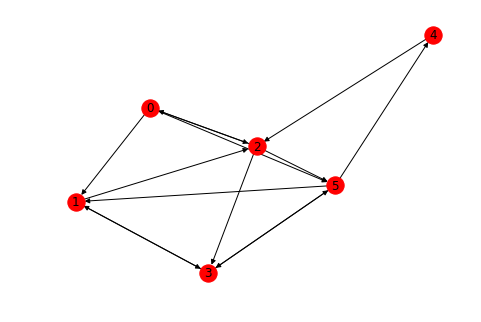

In [9]:
G=nx.from_numpy_matrix(I,create_using=nx.MultiDiGraph())
nx.draw(G,with_labels=True)

# Q2

For this question we will use the least squares function provided in the linalg library of numpy to estimate the coefficient matrice A

In [15]:
data = XX[:]
data.shape

(20, 300, 6)

In [23]:
X = np.asarray(XX[1:20,:,:].reshape(-1,6)[::-1])
Y = np.asarray(XX[0:19,:,:].reshape(-1,6)[::-1])

In [24]:
a = np.linalg.lstsq(X, Y)
a

/Users/nourghribi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(array([[ 0.1756831 ,  0.16143323,  0.69357485, -0.20720453, -0.08030037,
          0.08922994],
        [ 0.12392517, -0.063517  , -0.14850169,  0.51741394,  0.0580263 ,
         -0.48793853],
        [-0.11175009,  0.6928754 , -0.07618762,  0.25370263,  0.58765154,
          0.24365896],
        [-0.11863202,  0.27991526, -0.28426369, -0.21815702, -0.10089072,
         -0.33982937],
        [-0.31381494, -0.35180088, -0.0760884 ,  0.06405831, -0.11333782,
         -0.65603211],
        [-0.50835554, -0.02136978,  0.27841275,  0.40996637, -0.10346416,
         -0.28965374]]),
 array([4573.19151745, 5835.18281524, 4932.28512258, 3772.77946849,
        4631.09499106, 5011.30744064]),
 6,
 array([282.82430013, 183.01147894, 178.83873385,  81.13445928,
         73.11352895,  65.68065739]))

In [25]:
A = a[0]
A

array([[ 0.1756831 ,  0.16143323,  0.69357485, -0.20720453, -0.08030037,
         0.08922994],
       [ 0.12392517, -0.063517  , -0.14850169,  0.51741394,  0.0580263 ,
        -0.48793853],
       [-0.11175009,  0.6928754 , -0.07618762,  0.25370263,  0.58765154,
         0.24365896],
       [-0.11863202,  0.27991526, -0.28426369, -0.21815702, -0.10089072,
        -0.33982937],
       [-0.31381494, -0.35180088, -0.0760884 ,  0.06405831, -0.11333782,
        -0.65603211],
       [-0.50835554, -0.02136978,  0.27841275,  0.40996637, -0.10346416,
        -0.28965374]])

In [26]:
A.shape

(6, 6)